In [1]:
import sys
sys.path.append("../../")

In [2]:
import numpy as np
import torch
import torch.nn as nn
from botorch.test_functions.multi_objective import BraninCurrin
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.multi_objective.box_decompositions.dominated import DominatedPartitioning

from modules import SAB, PMA, ISAB

DEFAULT_EPS = 1e-10
PADDED_Y_VALUE = -1
tkwargs = {"device": "cpu", "dtype": torch.float}

In [43]:
def generate_initial_data(problem, n=6):
    # generate training data
    X_obs = torch.empty(0, problem.bounds.shape[-1], **tkwargs)
    y_obs = torch.empty(0, problem.ref_point.shape[-1], **tkwargs)
    while len(X_obs) < n:
        x = draw_sobol_samples(bounds=problem.bounds, n=1, q=1).squeeze(1)
        y = problem(x)
        if (y > problem.ref_point).all(dim=-1).item():
            X_obs = torch.concat([X_obs, x], dim=0)
            y_obs = torch.concat([y_obs, y], dim=0)

    return X_obs, y_obs


def hypervolume(y, ref_point):
    bd = DominatedPartitioning(ref_point=ref_point, Y=y)
    volume = bd.compute_hypervolume()
    return volume.view(-1, 1)

def inf_train_gen(dataloader):
    while True:
        for x, y in iter(dataloader): yield x, y

def gen_data(dataset, ref_point, batch_size):
    # number of x in a set
    max_length = dataset.tensors[0].shape[0]
    length = torch.randint(low=5, high=max_length + 1, size=(1,)).item()
    trainloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=length,
        shuffle=True,
        drop_last=True,
    )

    train_gen = inf_train_gen(trainloader)
    x_samples = torch.empty(0, length, dataset.tensors[0].shape[-1], **tkwargs)
    y_samples = torch.empty(0, 1, **tkwargs)
    for _ in range(batch_size):
        x, y = next(train_gen)
        x_samples = torch.concat([x_samples, x.unsqueeze(0)], dim=0)
        y_samples = torch.concat([y_samples, hypervolume(y, ref_point)], dim=0)

    return x_samples, y_samples

class SmallSetTransformer(nn.Module):
    def __init__(self, dim_in):
        super().__init__()
        self.enc = nn.Sequential(
            SAB(dim_in=dim_in, dim_out=64, num_heads=4),
            SAB(dim_in=64, dim_out=64, num_heads=4),
        )
        self.dec = nn.Sequential(
            PMA(dim=64, num_heads=4, num_seeds=1),
            nn.Linear(in_features=64, out_features=1),
        )

    def forward(self, x):
        x = self.enc(x)
        x = self.dec(x)
        return x.squeeze(-1)

class SetTransformer(nn.Module):
    def __init__(self, dim_input, num_outputs, dim_output,
            num_inds=32, dim_hidden=128, num_heads=4, ln=False):
        super(SetTransformer, self).__init__()
        self.enc = nn.Sequential(
                ISAB(dim_input, dim_hidden, num_heads, num_inds, ln=ln),
                ISAB(dim_hidden, dim_hidden, num_heads, num_inds, ln=ln))
        self.dec = nn.Sequential(
                PMA(dim_hidden, num_heads, num_outputs, ln=ln),
                SAB(dim_hidden, dim_hidden, num_heads, ln=ln),
                SAB(dim_hidden, dim_hidden, num_heads, ln=ln),
                nn.Linear(dim_hidden, dim_output))

    def forward(self, X):
        return self.dec(self.enc(X))

def train_model(model, X_obs, y_obs, ref_point, num_iter=1000):
    dataset = torch.utils.data.TensorDataset(*[X_obs, y_obs])

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#     scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
    criterion = listMLE_weighted
    losses = []
    batch_size = 8
    
    model.train()
    for i in range(num_iter):

        if (i+1) % 100 == 0:
            print(f"iteration {i+1}")
    
        x_samples, y_samples = gen_data(dataset=dataset, ref_point=ref_point, batch_size=batch_size)
        optimizer.zero_grad()

        preds = model(x_samples)
        loss = criterion(preds.view(1, -1), y_samples.view(1, -1))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
#         scheduler.step()
    model.eval()
    return model, losses

# The listMLE_weighted is an extended version of listMLE with weighting added to it.
def listMLE_weighted(y_pred, y_true, eps=DEFAULT_EPS, padded_value_indicator=PADDED_Y_VALUE):
    """
    ListMLE loss introduced in "Listwise Approach to Learning to Rank - Theory and Algorithm".
    :param y_pred: predictions from the model, shape [batch_size, slate_length]
    :param y_true: ground truth labels, shape [batch_size, slate_length]
    :param eps: epsilon value, used for numerical stability
    :param padded_value_indicator: an indicator of the y_true index containing a padded item, e.g. -1
    :return: loss value, a torch.Tensor
    """
    # shuffle for randomised tie resolution
    random_indices = torch.randperm(y_pred.shape[-1])
    y_pred_shuffled = y_pred[:, random_indices]
    y_true_shuffled = y_true[:, random_indices]

    y_true_sorted, indices = y_true_shuffled.sort(descending=True, dim=-1)

    mask = y_true_sorted == padded_value_indicator

    preds_sorted_by_true = torch.gather(y_pred_shuffled, dim=1, index=indices)
    preds_sorted_by_true[mask] = float("-inf")

    max_pred_values, _ = preds_sorted_by_true.max(dim=1, keepdim=True)

    preds_sorted_by_true_minus_max = preds_sorted_by_true - max_pred_values

    cumsums = torch.cumsum(preds_sorted_by_true_minus_max.exp().flip(dims=[1]), dim=1).flip(dims=[1])

    observation_loss = torch.log(cumsums + eps) - preds_sorted_by_true_minus_max

    observation_loss[mask] = 0.0

    ####### Weighting extension
    # Weighted ranking because it is more important to get the the first ranks right than the rest.
    weight = np.log(np.arange(observation_loss.shape[-1]) + 2)  # Adding 2 to prevent using log(0) & log(1) as weights.
    weight = np.array(weight, dtype=np.float32)
    weight = torch.from_numpy(weight)[None, :].to(**tkwargs)
    observation_loss = observation_loss / weight
    #######

    return torch.mean(torch.sum(observation_loss, dim=1))

iteration 100
iteration 200
iteration 300
iteration 400
iteration 500
iteration 600
iteration 700
iteration 800
iteration 900
iteration 1000


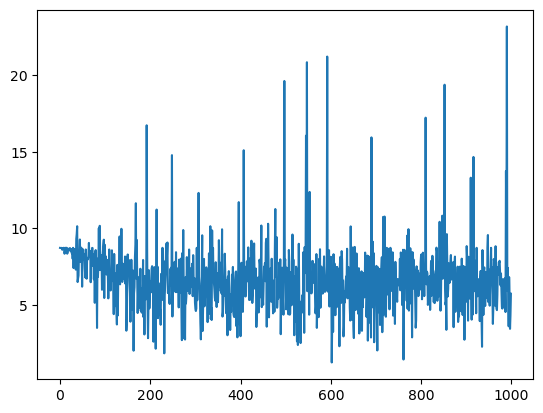

In [45]:
problem = BraninCurrin(negate=True).to(**tkwargs)
X_obs, y_obs = generate_initial_data(problem, n=100)
model = SmallSetTransformer(dim_in=2)
model.to(**tkwargs)
train = True

if train:
    model, losses = train_model(model, X_obs, y_obs, ref_point=problem.ref_point, num_iter=1000)
    torch.save(model.state_dict(), "./set_transformer.pt")

    import matplotlib.pyplot as plt
    plt.plot(losses);
else:
    model.load_state_dict(torch.load("./set_transformer.pt"))
    model.eval()

In [10]:
X_test, y_test = generate_initial_data(problem, n=50)

In [11]:
with torch.no_grad():
    pred = model(X_test[None, ...])